This code creates a buffer(50 meters max) around the spill points and finds the nearest flowline intersection, asserting that the operator name is the same. It then changes the matches spills geometry location to its respective flowline intersection point.

## Setup

In [2]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiLineString, LineString, Point
from shapely.ops import nearest_points

os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')
pd.options.display.max_columns = None

/var/folders/p3/gs65vvgs1wd90mnxb3q3hvy80000gp/T/ipykernel_1257/1675540171.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Load Data
all_flowlines_gdf = gpd.read_file('all_flowlines.geojson')
spills_gdf = gpd.read_file('spills.geojson')

In [4]:
# Check if CRS is the same for both files
if all_flowlines_gdf.crs != spills_gdf.crs:
    flowlines_gdf = all_flowlines_gdf.to_crs(spills_gdf.crs)

In [5]:
print(spills_gdf.crs)
print(all_flowlines_gdf.crs)

EPSG:26913
EPSG:26913


In [6]:
# Check size
print(all_flowlines_gdf.shape)
print(spills_gdf.shape)

(129785, 27)
(849, 14)


In [7]:
print(spills_gdf.is_valid.all())
print(all_flowlines_gdf.is_valid.all())

False
False


In [8]:
spills_gdf = spills_gdf[spills_gdf.is_valid]
all_flowlines_gdf = all_flowlines_gdf[all_flowlines_gdf.is_valid]

In [9]:
print(spills_gdf.is_valid.all())
print(all_flowlines_gdf.is_valid.all())

True
True


In [10]:
all_flowlines_gdf.head(2)

,index_left,LOCATION_ID,FLOWLINEID,STARTLOCATIONID,FLOWLINEACTION,ENTIRELINEREMOVED,ACTIONDESCRIPTION,RECEIVE_DATE,OPERATOR_NUM,COMPANY_NAME,LOCATIONTYPE,ENDLAT,ENDLONG,STARTLAT,STARTLONG,PIPEMATERIAL,BEDDINGMATERIAL,TYPEOFFLUIDTRANS,MAXOPPRESSURE,Operator,Fluid,Material,Diam_in,Status,Length_ft,SHAPE_Length,geometry
0,NaN,NaN,NaN,NaN,None,None,None,NaT,NaN,None,None,NaN,NaN,NaN,NaN,None,None,None,NaN,EVERGREEN NATURAL RESOURCES LLC,Gas,polly,4.0,Active,2277.71,693.972162,"MULTILINESTRING ((524642.670 4117088.796, 5246..."
1,NaN,NaN,NaN,NaN,None,None,None,NaT,NaN,None,None,NaN,NaN,NaN,NaN,None,None,None,NaN,NOBLE ENERGY INC,Multiphase,Carbon Steel,3.0,Abandoned,651.58,198.525215,"MULTILINESTRING ((527997.281 4463899.920, 5281..."


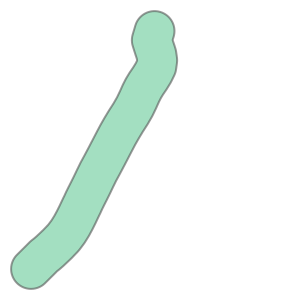

In [34]:

all_flowlines_gdf["geometry"].head(1)[0]
all_flowlines_gdf["geometry"].head(1).buffer(50)[0]

In [11]:
spills_gdf.head(2)

,trkg_num,Operator Name,facility_type,Spill_Desc,Spill Type,Root Cause,Preventative Measure,Root Cause Type,Detailed Root Cause Type,Long,Lat,facility_status,Metallic?,geometry
0,401530532,K P KAUFFMAN COMPANY INC,FLOWLINE,Historical contamination was discovered during...,1,Facility #7 consolidation line failed do to un...,The damaged section of flowline was repaired a...,Unknown,Unknown,-104.914183,40.019361,CL,Unknown,POINT (507323.245 4429909.631)
1,401524345,GREAT WESTERN OPERATING COMPANY LLC,TANK BATTERY,Soil impacts were discovered during removal of...,1,Unknown,None,Unknown,Unknown,-104.467746,39.602613,AC,Unknown,POINT (545695.434 4383787.964)


In [18]:
# Initialize an empty list to store matched data
matched_spills = []

max_buffer_distance = 49.5  # Maximum buffer distance in meters
initial_buffer_distance = 0  # Initial buffer distance
matches_found = 0  # Counter for matches found

for index, spill in spills_gdf.iterrows():
    # Check if two matches are already found
    if matches_found == 2:
        break
    
    # Check for missing geometry and skip if necessary
    if spill.geometry is None:
        print(f"Missing geometry for spill at index {index}. Skipping...")
        continue

    buffer_distance = initial_buffer_distance
    match_found = False

    while not match_found and buffer_distance <= max_buffer_distance:
        # Buffer the spill geometry
        buffered_spill = spill.geometry.buffer(buffer_distance)
        
        # Iterate over the segments of the all_flowlines_gdf
        for _, flowline in all_flowlines_gdf.iterrows():
            # Check if the buffer intersects with the flowline geometry
            if buffered_spill.intersects(flowline.geometry):
                # Get the intersection geometry
                intersection = buffered_spill.intersection(flowline.geometry)
                
                # If the intersection is a LineString, take an endpoint or a specific point
                if isinstance(intersection, LineString):
                    points = list(intersection.coords)
                    intersection_point = Point(points[0])  # Taking the first point of the LineString
                    
                elif isinstance(intersection, Point):
                    intersection_point = intersection
                else:
                    continue  # Skip if no suitable point can be derived
                
                # Check if the operator names match
                if spill['Operator Name'].strip().lower() == flowline['Operator'].strip().lower():
                    print(f"Operator match found at buffer distance {buffer_distance} meters for spill at index {index}.")
                    match_found = True
                    matches_found += 1  # Increment the counter for matches found

                    # Create a new GeoDataFrame with the updated spill
                    updated_spill = spill.copy()
                    updated_spill.geometry = intersection_point

                    # Append the updated spill to the list
                    matched_spills.append(updated_spill)
                    break

        if match_found:
            break
        else:
            buffer_distance += 20  # Increase buffer by 0.5 meters if no match found

    if not match_found:
        print(f"No operator match found for spill at index {index} even after expanding buffer to {buffer_distance} meters.")

# Convert the list of matched spills to a GeoDataFrame
matched_spills_gdf = gpd.GeoDataFrame(matched_spills, columns=spills_gdf.columns, crs=spills_gdf.crs)

No operator match found for spill at index 0 even after expanding buffer to 60 meters.
No operator match found for spill at index 1 even after expanding buffer to 60 meters.
No operator match found for spill at index 2 even after expanding buffer to 60 meters.
No operator match found for spill at index 3 even after expanding buffer to 60 meters.
No operator match found for spill at index 4 even after expanding buffer to 60 meters.
Operator match found at buffer distance 20 meters for spill at index 5.
Operator match found at buffer distance 20 meters for spill at index 6.


In [19]:
matched_spills_gdf.head()

,trkg_num,Operator Name,facility_type,Spill_Desc,Spill Type,Root Cause,Preventative Measure,Root Cause Type,Detailed Root Cause Type,Long,Lat,facility_status,Metallic?,geometry
5,401576719,NOBLE ENERGY INC,TANK BATTERY,During decommisioning of facilitiy soil impact...,1,Historical impacts were discovered during dism...,The site was dismantled and reclamation has oc...,Unknown,Unknown,-104.602541,40.319666,CL,Unknown,POINT (533748.677 4463317.692)
6,401585074,NOBLE ENERGY INC,TANK BATTERY,During reclamation activities historical impac...,1,During reclamation of the oil and gas facility...,The location was plugged and abandoned and exc...,Unknown,Unknown,-104.754486,40.484583,CL,Unknown,POINT (520822.624 4481586.136)


In [20]:
entire_dataset = gpd.sjoin(matched_spills_gdf, all_flowlines_gdf, how='right', op='intersects')
entire_dataset.head()

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ValueError: 'index_left' and 'index_right' cannot be names in the frames being joined

In [15]:
# Initialize an empty list to store matched data
matched_spills = []

max_buffer_distance = 49.5  # Maximum buffer distance in meters
initial_buffer_distance = 0  # Initial buffer distance
matches_found = 0  # Counter for matches found

for index, spill in spills_gdf.iterrows():
    # Check if two matches are already found
    if matches_found == 2:
        break
    
    # Check for missing geometry and skip if necessary
    if spill.geometry is None:
        print(f"Missing geometry for spill at index {index}. Skipping...")
        continue

    buffer_distance = initial_buffer_distance
    match_found = False

    while not match_found and buffer_distance <= max_buffer_distance:
        # Buffer the spill geometry
        buffered_spill = spill.geometry.buffer(buffer_distance)
        
        # Iterate over the segments of the all_flowlines_gdf
        for _, flowline in all_flowlines_gdf.iterrows():
            # Check if the buffer intersects with the flowline geometry
            if buffered_spill.intersects(flowline.geometry):
                # Find the intersection point
                intersection_point = buffered_spill.intersection(flowline.geometry)
                
                # Check if the operator names match
                if spill['Operator Name'].strip().lower() == flowline['Operator'].strip().lower():
                    print(f"Operator match found at buffer distance {buffer_distance} meters for spill at index {index}.")
                    match_found = True
                    matches_found += 1  # Increment the counter for matches found

                    # Create a new GeoDataFrame with the updated spill
                    updated_spill = spill.copy()
                    updated_spill.geometry = intersection_point

                    # Append the updated spill to the list
                    matched_spills.append(updated_spill)
                    break

        if match_found:
            break
        else:
            buffer_distance += 10  # Increase buffer by 0.5 meters if no match found

    if not match_found:
        print(f"No operator match found for spill at index {index} even after expanding buffer to {buffer_distance} meters.")

# Convert the list of matched spills to a GeoDataFrame
matched_spills_gdf = gpd.GeoDataFrame(matched_spills, columns=spills_gdf.columns, crs=spills_gdf.crs)

No operator match found for spill at index 0 even after expanding buffer to 50 meters.
No operator match found for spill at index 1 even after expanding buffer to 50 meters.
No operator match found for spill at index 2 even after expanding buffer to 50 meters.
No operator match found for spill at index 3 even after expanding buffer to 50 meters.
No operator match found for spill at index 4 even after expanding buffer to 50 meters.
Operator match found at buffer distance 20 meters for spill at index 5.
Operator match found at buffer distance 20 meters for spill at index 6.


In [16]:
matched_spills_gdf.head()

,trkg_num,Operator Name,facility_type,Spill_Desc,Spill Type,Root Cause,Preventative Measure,Root Cause Type,Detailed Root Cause Type,Long,Lat,facility_status,Metallic?,geometry
5,401576719,NOBLE ENERGY INC,TANK BATTERY,During decommisioning of facilitiy soil impact...,1,Historical impacts were discovered during dism...,The site was dismantled and reclamation has oc...,Unknown,Unknown,-104.602541,40.319666,CL,Unknown,"LINESTRING (533748.677 4463317.692, 533756.613..."
6,401585074,NOBLE ENERGY INC,TANK BATTERY,During reclamation activities historical impac...,1,During reclamation of the oil and gas facility...,The location was plugged and abandoned and exc...,Unknown,Unknown,-104.754486,40.484583,CL,Unknown,"LINESTRING (520822.624 4481586.136, 520825.511..."


In [32]:
# Initialize an empty GeoDataFrame to store the updated spills
matched_spills_gdf = gpd.GeoDataFrame(columns=spills_gdf.columns, crs=spills_gdf.crs)

max_buffer_distance = 49.5  # Maximum buffer distance in meters
initial_buffer_distance = 0  # Initial buffer distance

for index, spill in spills_gdf.iterrows():
    buffer_distance = initial_buffer_distance
    match_found = False
    
    while not match_found and buffer_distance <= max_buffer_distance:
        # Buffer the spill geometry
        buffered_spill = spill.geometry.buffer(buffer_distance)
        temp_spill_gdf = gpd.GeoDataFrame([spill], geometry=[buffered_spill], crs=spills_gdf.crs)
        
        # Perform the spatial join
        joined_gdf = gpd.sjoin(temp_spill_gdf, all_flowlines_gdf, how='inner', predicate='intersects')

        if not joined_gdf.empty:
            for _, match in joined_gdf.iterrows():
                if match['Operator Name'].strip().lower() == match['Operator'].strip().lower():
                    print(f"Operator match found at buffer distance {buffer_distance} meters for spill at index {index}.")
                    match_found = True
                    
                    # Find the nearest point on the flowline to the original spill location
                    nearest_geom = nearest_points(spill.geometry, match.geometry)[1]
                    
                    # Update the spill's geometry to this nearest point
                    updated_spill = spill.copy()
                    updated_spill.geometry = nearest_geom
                    
                    # Append the updated spill to the matched_spills_gdf
                    # matched_spills_gdf = matched_spills_gdf.append(updated_spill, ignore_index=True)
                    matched_spills_gdf = pd.concat([matched_spills_gdf, gpd.GeoDataFrame([updated_spill], crs=spills_gdf.crs)], ignore_index=True)

                    
                    break
            
            if match_found:
                break
        
        if not match_found:
            buffer_distance += .5

    if not match_found:
        print(f"No match found for spill at index {index} even after expanding buffer to {buffer_distance} meters.")

No match found for spill at index 0 even after expanding buffer to 50.0 meters.
No match found for spill at index 1 even after expanding buffer to 50.0 meters.
No match found for spill at index 2 even after expanding buffer to 50.0 meters.
No match found for spill at index 3 even after expanding buffer to 50.0 meters.
No match found for spill at index 4 even after expanding buffer to 50.0 meters.
No match found for spill at index 5 even after expanding buffer to 50.0 meters.
No match found for spill at index 6 even after expanding buffer to 50.0 meters.
No match found for spill at index 7 even after expanding buffer to 50.0 meters.
No match found for spill at index 8 even after expanding buffer to 50.0 meters.
No match found for spill at index 9 even after expanding buffer to 50.0 meters.
No match found for spill at index 10 even after expanding buffer to 50.0 meters.
No match found for spill at index 11 even after expanding buffer to 50.0 meters.
No match found for spill at index 12 e

KeyboardInterrupt: 

In [ ]:
matched_spills_gdf.head()

In [12]:
matched_spills_gdf.to_file("matched_spills.geojson", driver='GeoJSON')

In [13]:
matched_spills_gdf.shape

(417, 14)

In [3]:
all_flowlines_gdf = gpd.read_file('all_flowlines.geojson')
matched_spills_gdf = gpd.read_file('matched_spills.geojson')

In [4]:
# Load Data
# Spatial join to find intersecting geometries
# Add attributes from flowlines to matching entries in crude_oil_gdf
complete_data = gpd.sjoin(all_flowlines_gdf, matched_spills_gdf, how="inner", op='intersects')
complete_data.shape

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


(0, 40)

In [5]:
# Step 1: Ensure CRS match
if all_flowlines_gdf.crs != matched_spills_gdf.crs:
    matched_spills_gdf = matched_spills_gdf.to_crs(all_flowlines_gdf.crs)

# Optional: Visual inspection or logging to confirm updates
# print(matched_spills_gdf.head())

# Step 2: Perform the spatial join again with the corrected GeoDataFrames
complete_data = gpd.sjoin(all_flowlines_gdf, matched_spills_gdf, how="inner", predicate='intersects')

# Check the result
if complete_data.empty:
    print("No intersections found. Check geometry updates and CRS settings.")
else:
    print(complete_data.shape)


No intersections found. Check geometry updates and CRS settings.
